In [33]:
import awkward as ak
import uproot
import numpy as np
import matplotlib.pyplot as plt
import sys
import yaml
import matplotlib.pyplot as plt
from numpy import genfromtxt

sys.path.append('/home/jbohm/start_tf/LCStudies')
from  util import graph_util as gu
from data import particle_data_visualize_plot_utils as pu

In [67]:
# compute mse per cluster and then average over batch or file
def mse_batch(labels, preds):
    return np.mean(np.mean(np.square(labels - preds), axis=1))

def mse_batch_no_pad(preds, labels):
    sum = 0
    count = 0
    for i, clus_labels in enumerate(labels):
        cut_padding = (clus_labels != 0)
        if len(clus_labels[cut_padding] != 0):
            sum += np.mean(np.square(clus_labels[cut_padding] - preds[i][cut_padding]))
            count += 1
    return sum / count

# slice and plot loss
def plot_batch_loss(all_loss, batch_low=None, batch_high=None):
    batch_high = len(all_loss) if batch_high == None else batch_high
    batch_low = 0 if batch_low == None else batch_low
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(np.arange(batch_low, batch_high), all_loss[batch_low:batch_high])
    plt.xlabel("batch")
    plt.ylabel("loss")
    plt.show()

def plot_epoch_loss(train_loss, val_loss):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(train_loss, label="train")
    plt.plot(val_loss, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

def get_history(file_name):
    return np.load("/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/" + file_name, allow_pickle=True)

def plot_clus_pred_acc(clus_idx, preds, labels, verbose=False, point_low=None, point_high=None):
    if point_low == None and point_high == None:
        point_low = 0
        point_high = len(labels[clus_idx][labels[clus_idx] != 0]) + 10

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.scatter(np.arange(point_low, point_high), labels[clus_idx][point_low:point_high], label="truth")
    plt.scatter(np.arange(point_low, point_high), preds[clus_idx][point_low:point_high], label="preds")
    plt.plot(np.arange(point_low, point_high), np.repeat(np.mean(labels[clus_idx][labels[clus_idx] != 0]), point_high - point_low), color="grey")
    plt.xlabel("point")
    plt.ylabel("EM frac")
    plt.title("Cluster " + str(clus_idx))
    plt.legend()
    plt.show()
    if verbose:
        print("cluster" + str(clus_idx) + ", cells " + str(point_low) + " to " + point_high)
        print("predicted EM frac:")
        print(preds[clus_idx][point_low:point_high].flatten())
        print("truth:")
        print(labels[clus_idx][point_low:point_high].flatten())

def plot_clus_preds_acc(clus_idxs, preds, labels, epochs, verbose=False, point_low=None, point_high=None):
    calc_range = False
    if point_low == None and point_high == None:
        calc_range = True
        
    for clus_idx in clus_idxs:
        if calc_range:
            point_low = 0
            point_high = len(labels[clus_idx][labels[clus_idx] != 0]) + 10

        fig = plt.figure(figsize=(15,3))
        fig.patch.set_facecolor('white')
        plt.scatter(np.arange(point_low, point_high), labels[clus_idx][point_low:point_high], label="truth")
        for epoch in epochs:
            plt.scatter(np.arange(point_low, point_high), preds[epoch][clus_idx][point_low:point_high], label="epoch " + str(epoch))
        plt.plot(np.arange(point_low, point_high), np.repeat(np.mean(labels[clus_idx][labels[clus_idx] != 0]), point_high - point_low), color="grey")
        plt.xlabel("point")
        plt.ylabel("EM frac")
        plt.title("Cluster " + str(clus_idx) + " preds")
        plt.legend()
        plt.show()

def plot_all_clus_acc(history):
    true_points_cut = (history["labels"] != 0)
    all_labels = history["labels"][true_points_cut].flatten()
    all_preds = history["preds"][true_points_cut].flatten()
    pu.plot_overlay_hist([all_labels, all_preds], 100, "All clusters", "EM frac", "frequency", ["truth", "preds"])
    

In [181]:
# compare Russell's different models

# gamma
def get_model_data(name):
    # with Masking layer applied at beggining
    history = np.load("/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/history_6_files_" + name + ".npz", allow_pickle=True)

    # compute mse for points that are not masked out
    print("mse", np.mean(np.square(history["labels"] - history["preds"])))
    print(history["preds"][0][:20].flatten())
    print(history["labels"][0][:20].flatten())

get_model_data("gamma") # sets all values to 1
get_model_data("omicron")
get_model_data("delta")

# TODO: determine why are these all identical??

mse 0.9376966450361149
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.30507627 1.         0.79853743 0.12058365 0.99844193 0.96814859
 0.99958527 1.         0.31151381 0.5953508  1.         0.86264044
 0.8490988  0.         0.         0.         0.         0.
 0.         0.        ]
mse 0.9376966450361149
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.30507627 1.         0.79853743 0.12058365 0.99844193 0.96814859
 0.99958527 1.         0.31151381 0.5953508  1.         0.86264044
 0.8490988  0.         0.         0.         0.         0.
 0.         0.        ]
mse 0.9376966450361149
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.30507627 1.         0.79853743 0.12058365 0.99844193 0.96814859
 0.99958527 1.         0.31151381 0.5953508  1.         0.86264044
 0.8490988  0.         0.         0.         0.         0.
 0.         0.        ]


history_6_files_gamma.npz
mse (all data) = 0.9376966450361145


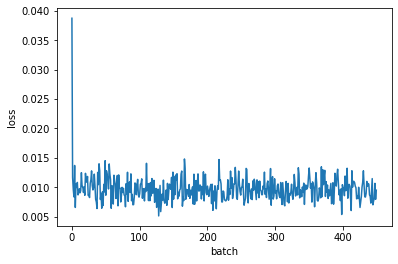

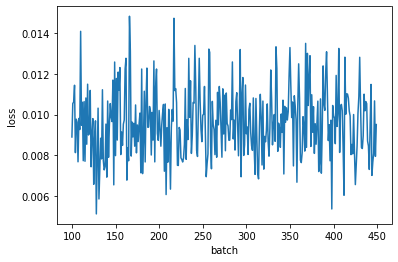

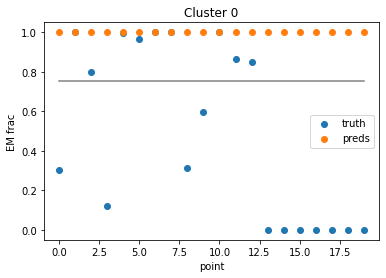

history_6_files_gamma_no_mask.npz
mse (all data) = 0.04996181434974635


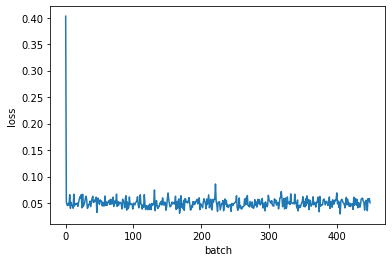

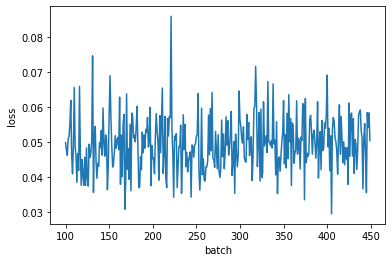

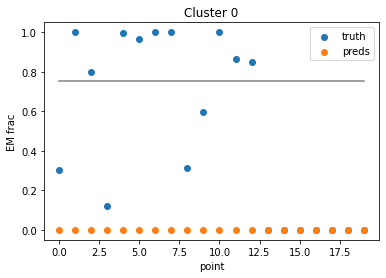

history_6_files_gamma_no_mask_plus_regularization.npz
mse (all data) = 0.04996181434974635


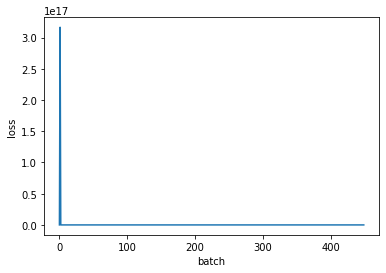

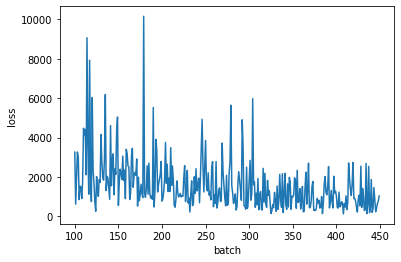

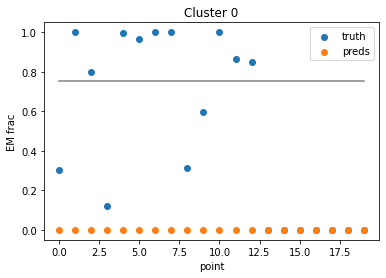

history_6_files_gamma_no_mask_plus_regualrization_no_x_shape.npz
mse (all data) = 0.04996181434974635


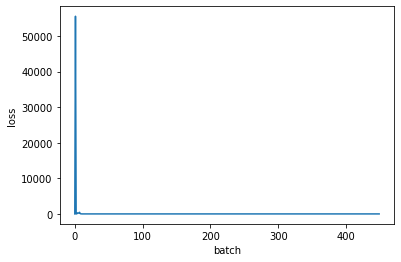

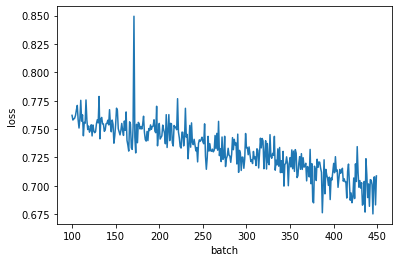

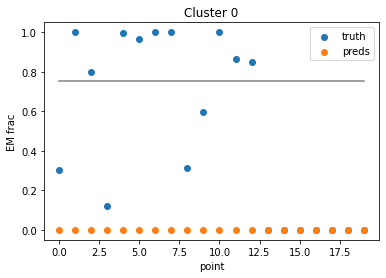

In [182]:
# gamma w/out masking
def get_model_label_data(file_name):
    print(file_name)
    history = get_history(file_name)
    print("mse (all data) =", mse_batch(history["preds"], history["labels"]))
    
    plot_batch_loss(history["loss"])
    plot_batch_loss(history["loss"], 100)
    plot_clus_pred_acc(0, history)

get_model_label_data("history_6_files_gamma.npz")
get_model_label_data("history_6_files_gamma_no_mask.npz")
get_model_label_data("history_6_files_gamma_no_mask_plus_regularization.npz")
get_model_label_data("history_6_files_gamma_no_mask_plus_regualrization_no_x_shape.npz")

history_segmentation_150_files_5_epochs_64_batch_size.npz:


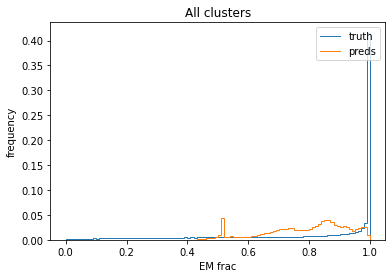

mse: 0.0042705475835245425


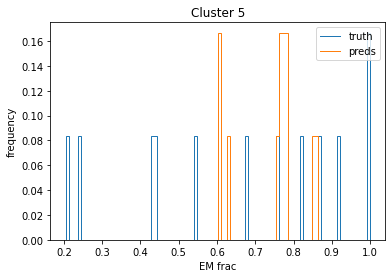

mse (no padding): 0.0989364358948025


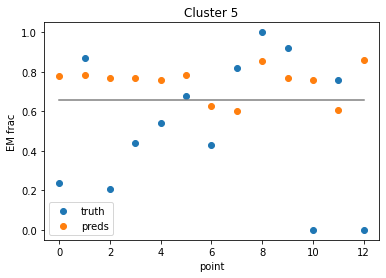

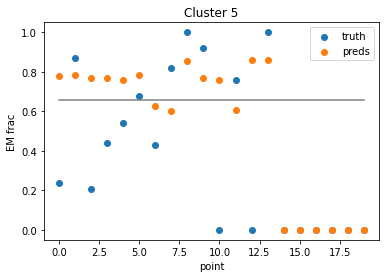

history_segmentation_50_files_25_epochs_64_batch_size.npz:


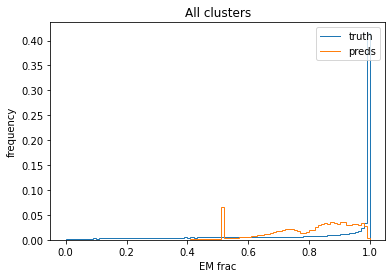

mse: 0.004195212506803577


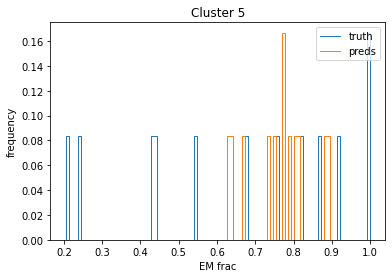

mse (no padding): 0.10017558386340758


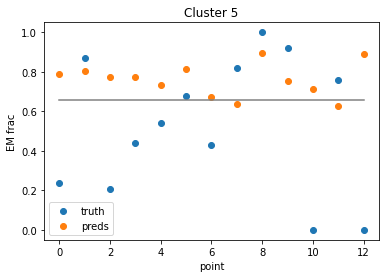

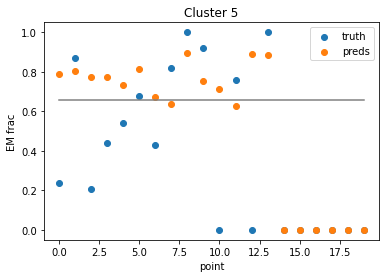

In [28]:
def visualize_pred_accuracy(file_name, cluster_idx, verbose=False):
    print(file_name + ":")
    history = get_history(file_name)
    true_points_cut = (history["labels"][cluster_idx] != 0)
    labels = history["labels"][cluster_idx][true_points_cut].flatten()
    preds = history["preds"][cluster_idx][true_points_cut].flatten()

    plot_all_clus_acc(history)

    print("mse:", mse_batch(history["preds"], history["labels"]))
    pu.plot_overlay_hist([labels, preds], 100, "Cluster " + str(cluster_idx), "EM frac", "frequency", ["truth", "preds"])
    print("mse (no padding):", mse_batch_no_pad(history["preds"], history["labels"]))
   

    plot_clus_pred_acc(cluster_idx, history, verbose, 0, 13)
    plot_clus_pred_acc(cluster_idx, history, verbose, 0, 20)

visualize_pred_accuracy("history_segmentation_150_files_5_epochs_64_batch_size.npz", 5)
visualize_pred_accuracy("history_segmentation_50_files_25_epochs_64_batch_size.npz", 5)
    

history_segmentation_150_files_5_epochs_64_batch_size.npz
mse (all data) = 0.0042705475835245425


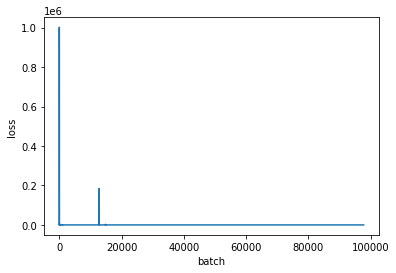

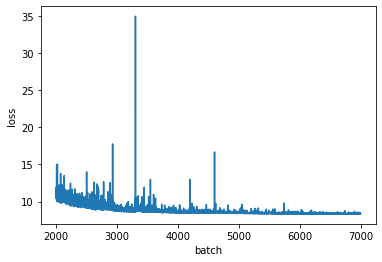

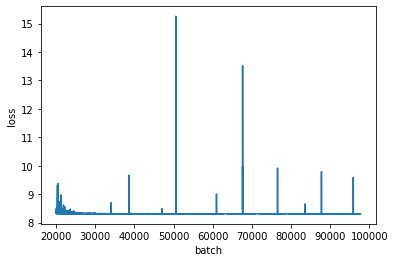

history_segmentation_50_files_25_epochs_64_batch_size.npz
mse (all data) = 0.004195212506803577


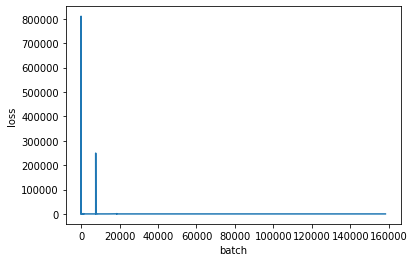

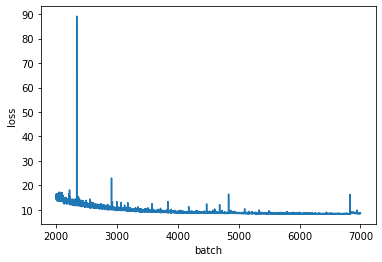

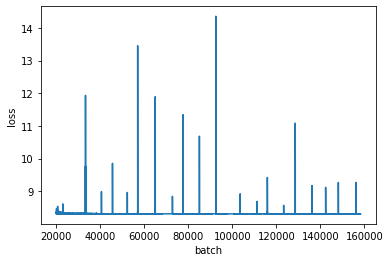

In [184]:
# generic point cloud testing:
def get_performance_data(file_name, cuts=[[None, None]]):
    print(file_name)
    history = get_history(file_name)
    print("mse (all data) =", mse_batch(history["labels"], history["preds"]))
    for cut in cuts:
        plot_batch_loss(history["loss"], cut[0], cut[1])
    
    
#get_performance_data("test_5_epochs.npz") # 6 files, generic segmentation model
cuts = [[None, None], [2000, 7000], [20000, None]]
get_performance_data("history_segmentation_150_files_5_epochs_64_batch_size.npz", cuts)
get_performance_data("history_segmentation_50_files_25_epochs_64_batch_size.npz", cuts)

# NOTE:
#   - with 150 files, 5 epochs - converges around batch 6000
#   - mse = 0.00427 (including padding), mse = 0.0797 (no padding)
#   - with 50 files, 25 epochs - converges around batch 5000
#   - mse = 0.004195 (including padding), mse = 0.0798(no padding)

history_mask_testing_25_files_no_mask.npz
mse (all data) = 0.005993274268118932


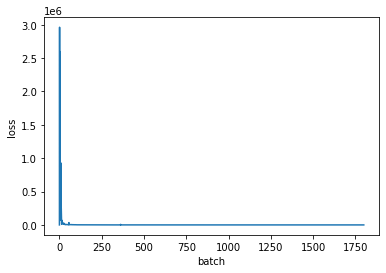

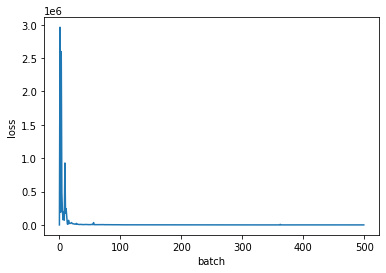

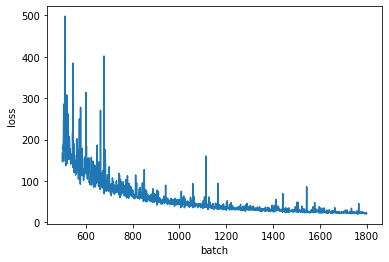

history_mask_testing_25_files_no_mask.npz:
mse = 0.11924449527385583


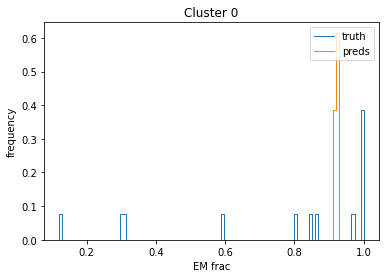

mse (no padding)= 0.07123781736474179


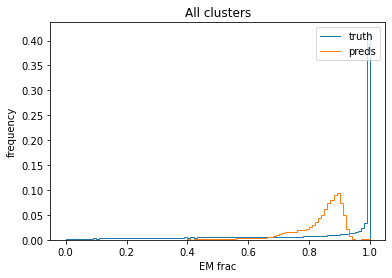

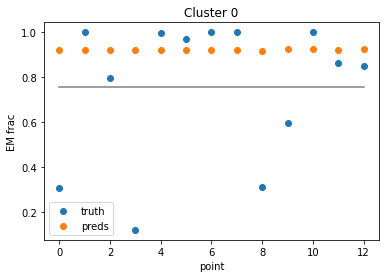

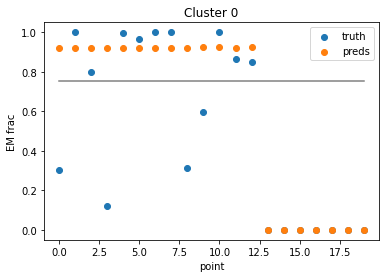

history_mask_testing_25_files_mask.npz
mse (all data) = 0.005890698944959698


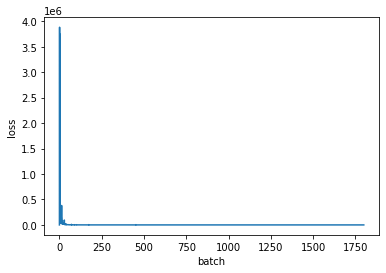

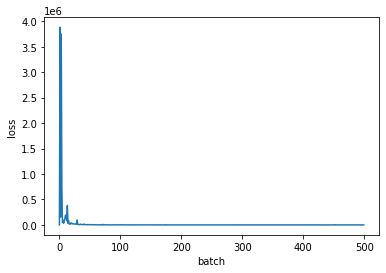

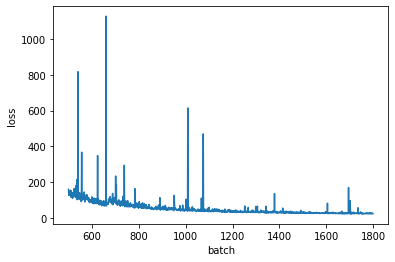

history_mask_testing_25_files_mask.npz:
mse = 0.11034968724625831


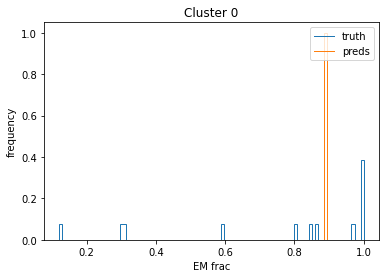

mse (no padding)= 0.07102010309810415


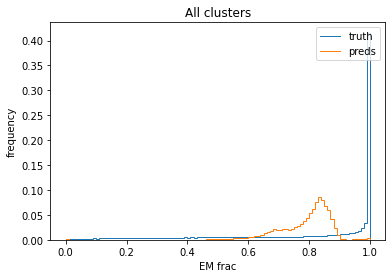

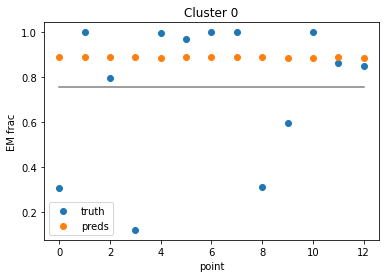

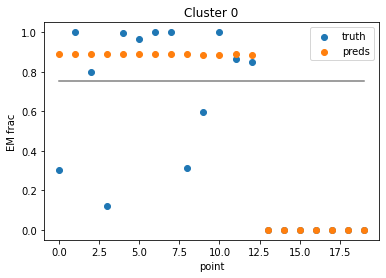

In [185]:
# masked output testing - on generic PointNet segmentation
# with Masking layer applied at beggining
cuts = [[None, None], [None, 500], [500, None]]
files = ["history_mask_testing_25_files_no_mask.npz", "history_mask_testing_25_files_mask.npz"]

for file in files:
    get_performance_data(file, cuts)
    visualize_pred_accuracy(file, 0)



history_segmentation_6_files_no_mask.npz
mse (all data) = 0.005839135688332028


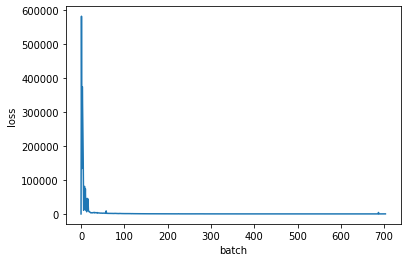

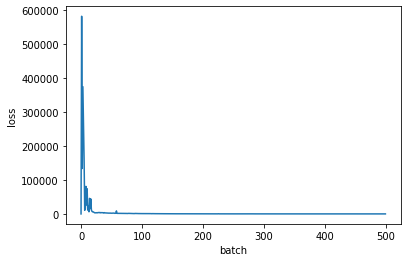

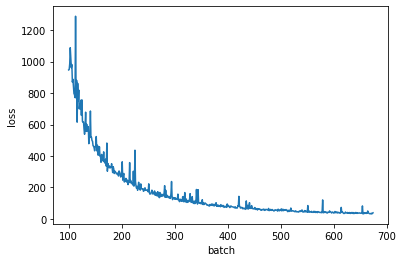

history_segmentation_6_files_no_mask.npz:
mse = 0.09609100603789268


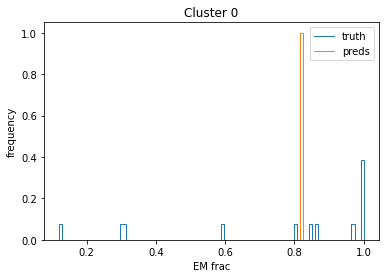

mse (no padding)= 0.08191830294518412


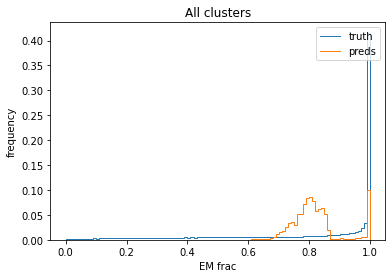

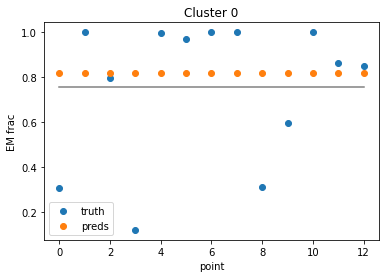

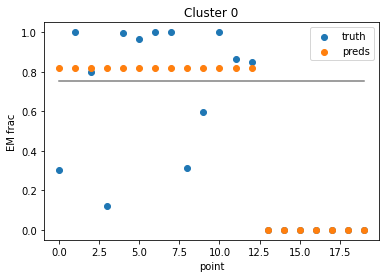

history_segmentation_6_files_mask_propagate.npz
mse (all data) = 0.7235388236094024


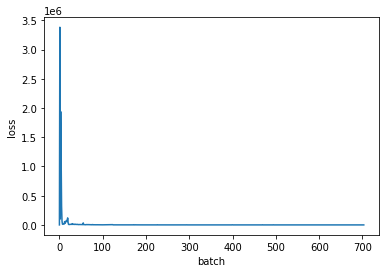

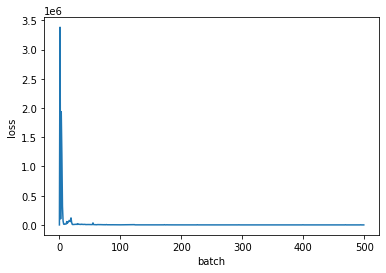

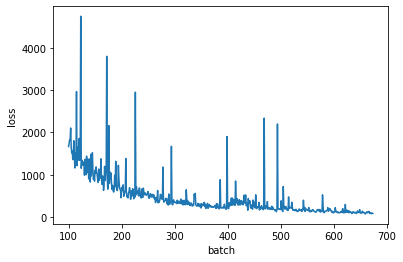

history_segmentation_6_files_mask_propagate.npz:
mse = 0.09846077474614266


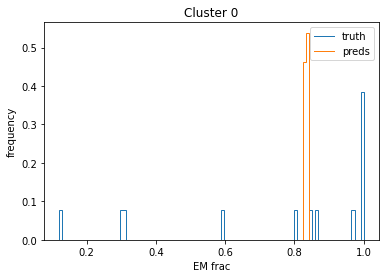

mse (no padding)= 0.07667222698145336


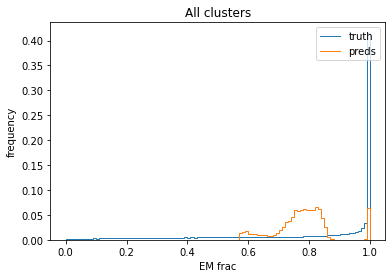

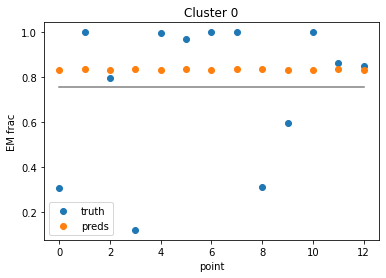

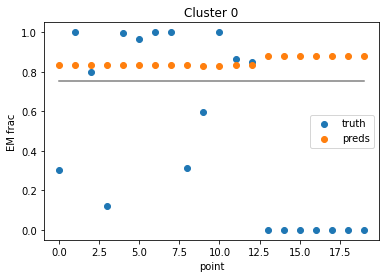

history_segmentation_6_files_mask_propagate_dont_pass.npz
mse (all data) = 0.005864911057332612


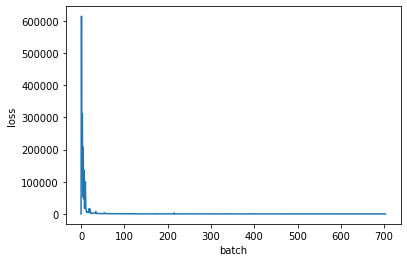

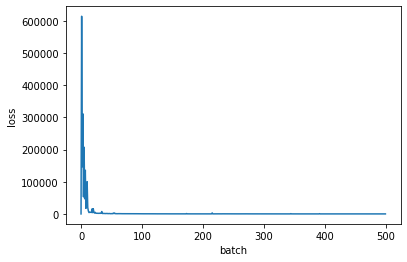

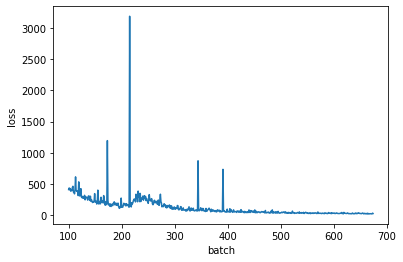

history_segmentation_6_files_mask_propagate_dont_pass.npz:
mse = 0.09775571616368389


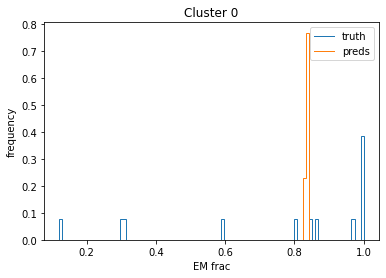

mse (no padding)= 0.08189351126950062


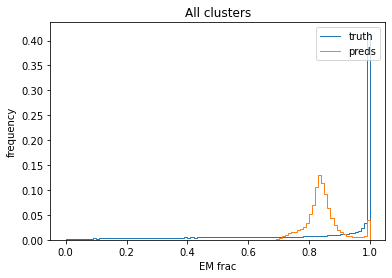

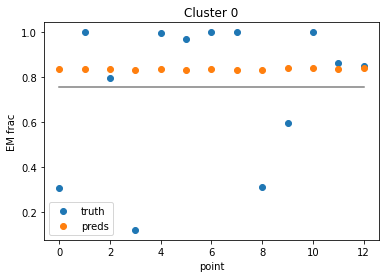

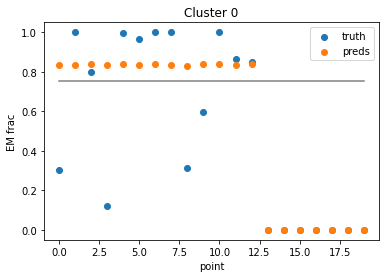

history_segmentation_25_files_mask_propagate.npz
mse (all data) = 0.784332076155283


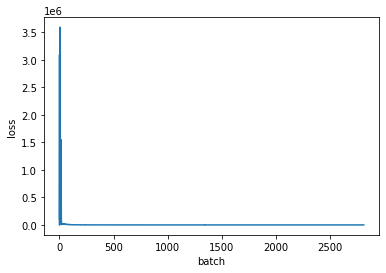

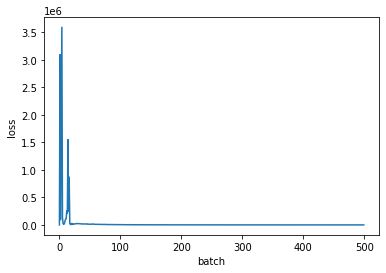

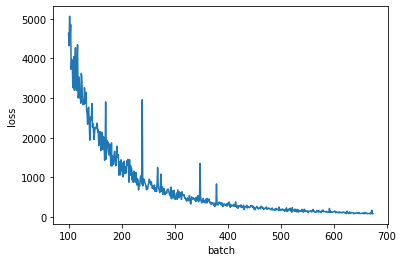

history_segmentation_25_files_mask_propagate.npz:
mse = 0.12069400382562456


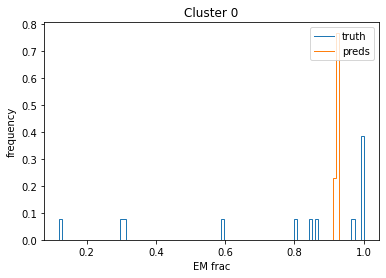

mse (no padding)= 0.07408549235099739


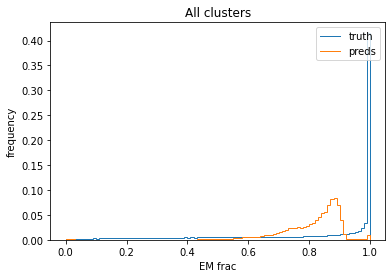

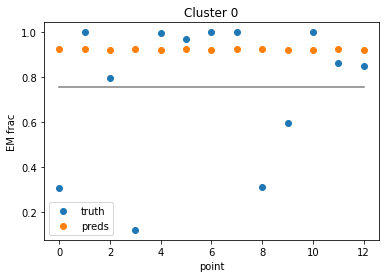

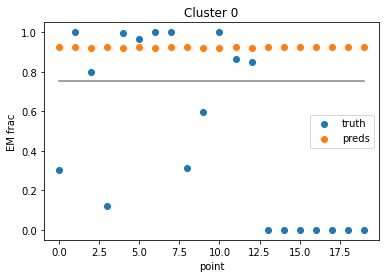

history_segmentation_25_files_5_epochs_mask_propagate.npz
mse (all data) = 0.6769141705437657


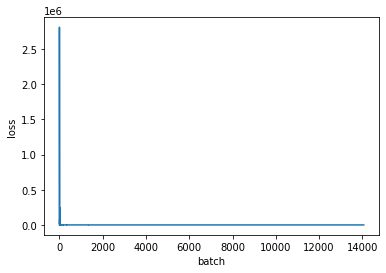

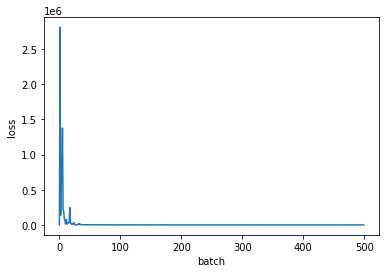

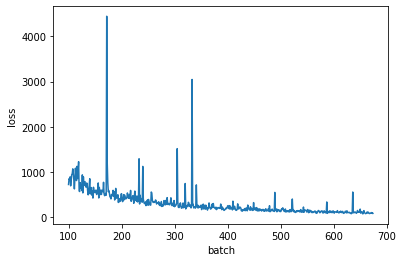

history_segmentation_25_files_5_epochs_mask_propagate.npz:
mse = 0.1093984891180627


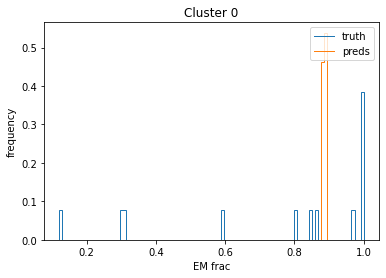

mse (no padding)= 0.070827716288616


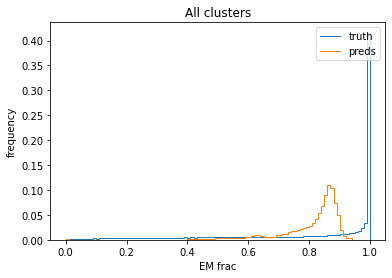

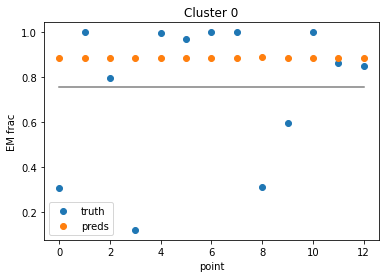

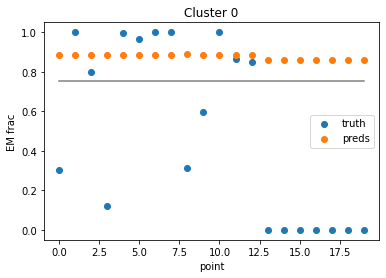

In [186]:
# masked output testing - on generic PointNet segmentation
# with Masking layer applied at beggining
cuts = [[None, None], [None, 500], [100, 675]]
files = ["history_segmentation_6_files_no_mask.npz", "history_segmentation_6_files_mask_propagate.npz", "history_segmentation_6_files_mask_propagate_dont_pass.npz", "history_segmentation_25_files_mask_propagate.npz", "history_segmentation_25_files_5_epochs_mask_propagate.npz"]

for file in files:
    get_performance_data(file, cuts)
    visualize_pred_accuracy(file, 0)

# NOTE: cast to zeros was not included in tNet :( for "history_segmentation_6_files_mask_propagate.npz", "history_segmentation_6_files_mask_propagate_dont_pass.npz",
#  "history_segmentation_25_files_mask_propagate.npz", "history_segmentation_25_files_5_epochs_mask_propagate.npz"


history_segmentation_25_files_5_epochs_mask_propagate.npz
mse (all points): 0.6769141705437657
mse (no pad): 0.12093946527600946


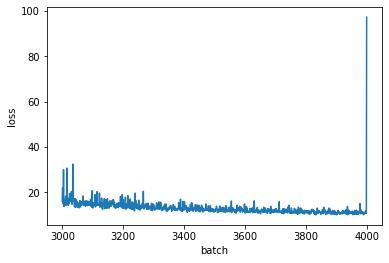

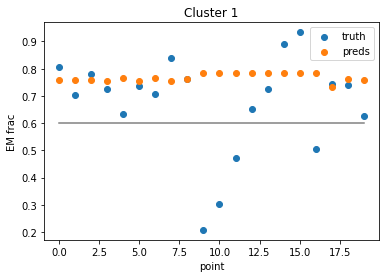

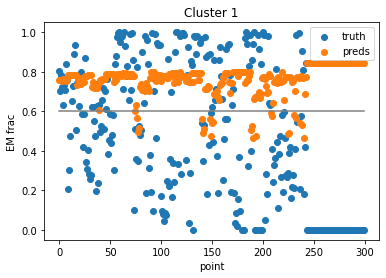

history_segmentation_25_files_5_epochs_mask_propagate_fix.npz
mse (all points): 0.7290882513907863
mse (no pad): 0.11902427489746022


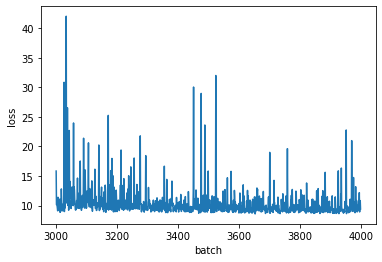

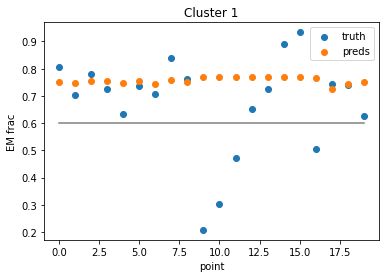

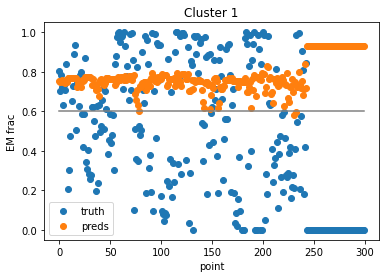

In [187]:
files = ["history_segmentation_25_files_5_epochs_mask_propagate.npz", "history_segmentation_25_files_5_epochs_mask_propagate_fix.npz"] #["history_segmentation_25_files_no_mask.npz", "history_segmentation_25_files_mask_propagate.npz", "history_segmentation_25_files_mask_propagate_fix.npz", "history_segmentation_25_files_5_epochs_mask_propagate.npz", "history_segmentation_25_files_5_epochs_mask_propagate_fix.npz"]#"history_gamma_6_files_BN.npz"]

for file in files:
    print(file)
    history = get_history(file)
    cluster_idx = 1

    print("mse (all points):", mse_batch(history["preds"], history["labels"]))
    print("mse (no pad):", mse_batch_no_pad(history["preds"], history["labels"]))
   
    plot_batch_loss(history["loss"], 3000, 4000)
    plot_clus_pred_acc(cluster_idx, history, 0, 20)
    plot_clus_pred_acc(cluster_idx, history, 0, 300)



history_gamma_25_files_BN.npz
mse (all points): 0.6726411147325013
mse (no pad): 0.11333598596038362


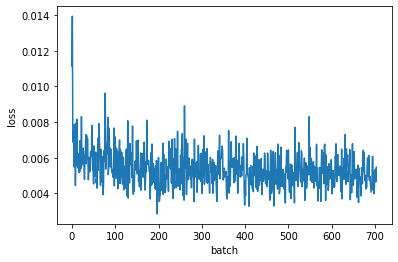

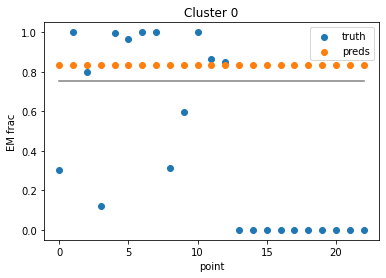

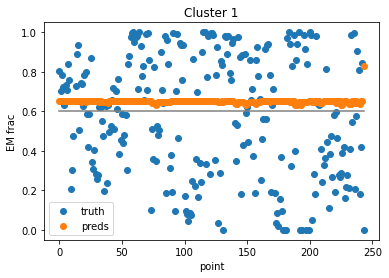

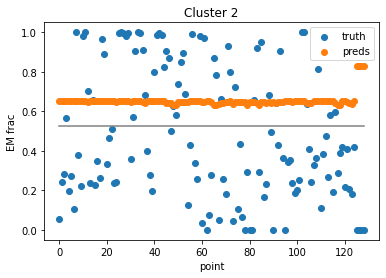

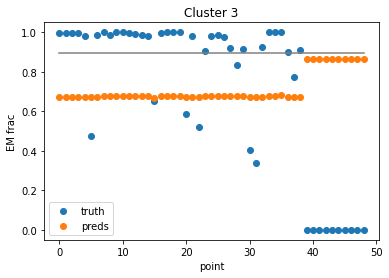

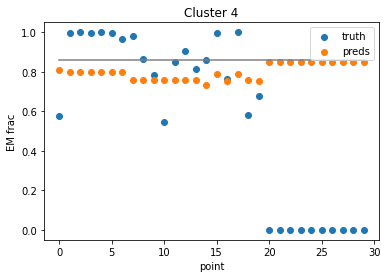

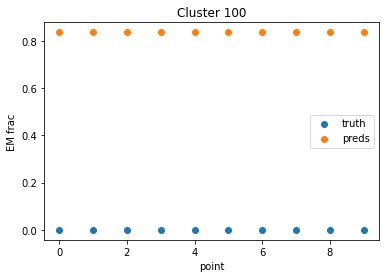

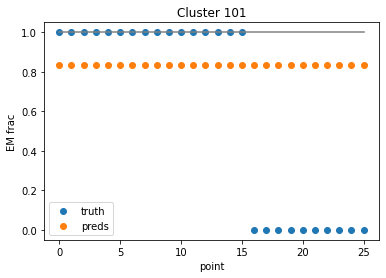

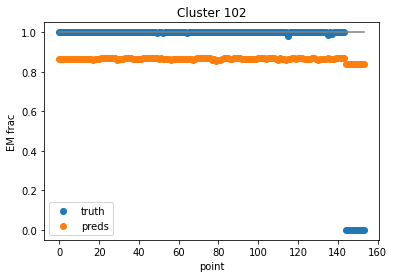

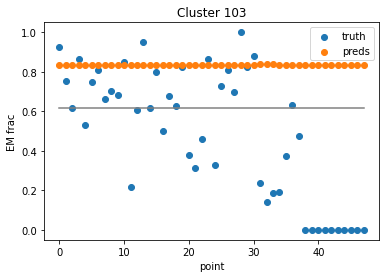

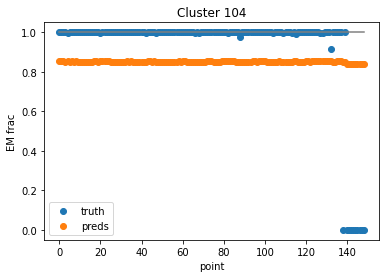

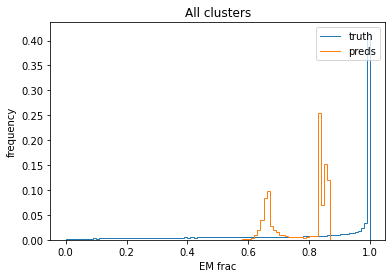

history_gamma_150_files_5_epochs_BN_cartesian.npz
mse (all points): 0.6867769605167843
mse (no pad): 0.08603569697404354


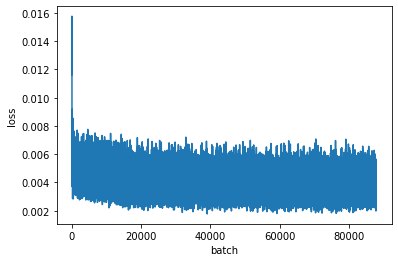

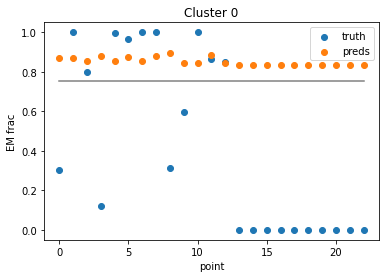

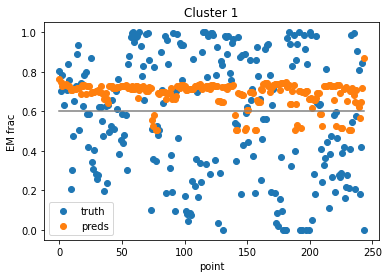

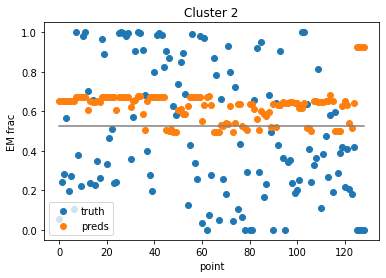

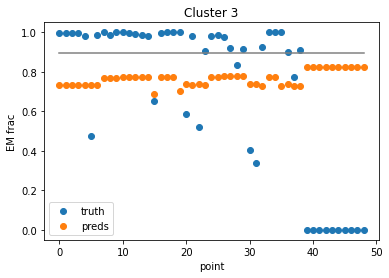

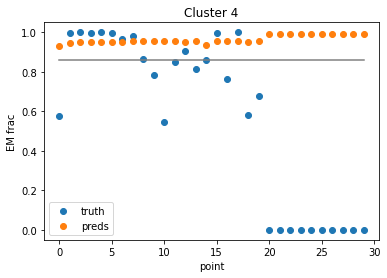

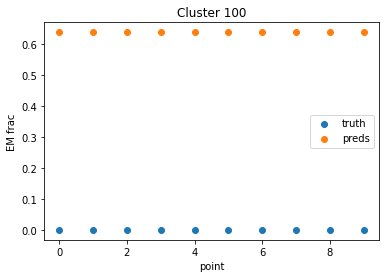

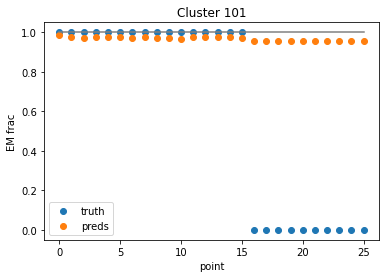

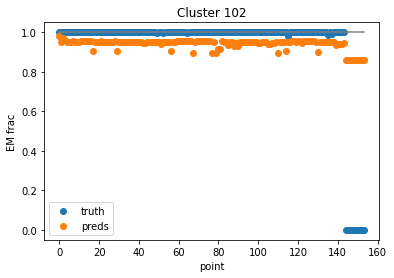

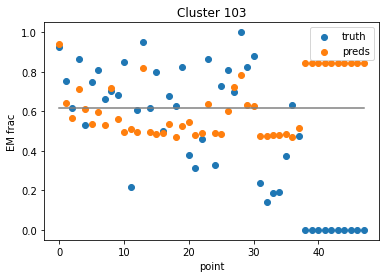

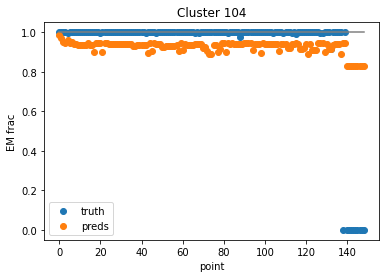

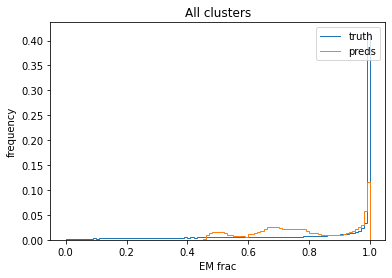

In [26]:
files = ["history_gamma_25_files_BN.npz", "history_gamma_150_files_5_epochs_BN_cartesian.npz"] # "/history_gamma_1_tr_3_tst_1_val_1_epoch_BN_cartesian.npz"

for file in files:
    print(file)
    history = get_history(file)
    cluster_idxs = [0, 1, 2, 3, 4, 100, 101, 102, 103, 104]

    print("mse (all points):", mse_batch(history["preds"], history["labels"]))
    print("mse (no pad):", mse_batch_no_pad(history["preds"], history["labels"]))

    plot_batch_loss(history["loss"])
    for cluster_idx in cluster_idxs:
        plot_clus_pred_acc(cluster_idx, history)

    plot_all_clus_acc(history)

history_gamma_325_tr_40_tst_40_val_5_epoch_BN_cartesian.npz
got preds
got labels


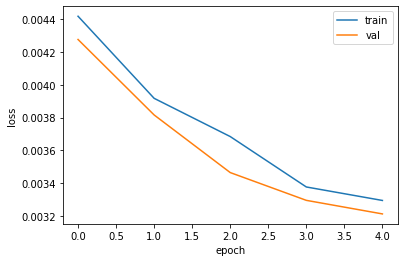

mse (all points): 0.6112571345825302
mse (no pad): 0.06986874978789445


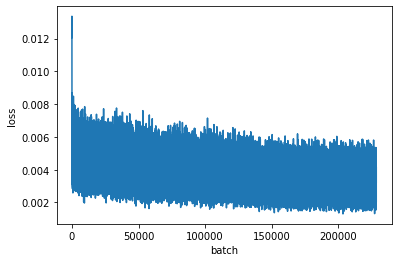

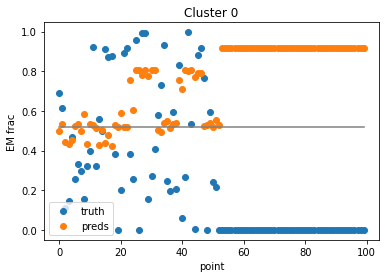

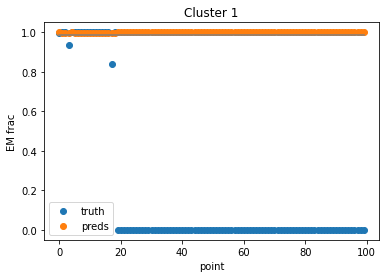

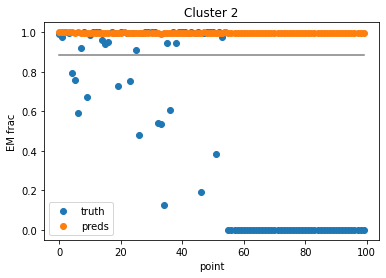

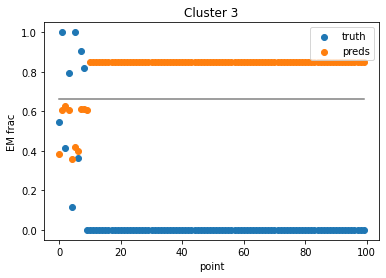

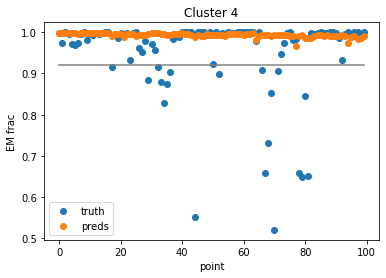

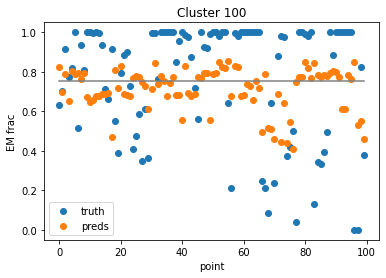

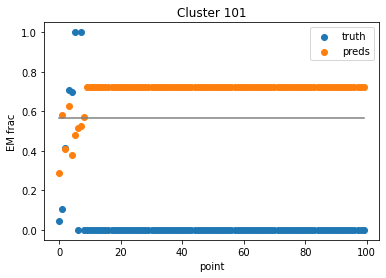

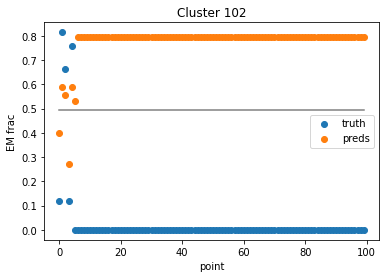

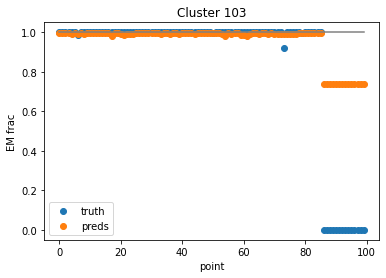

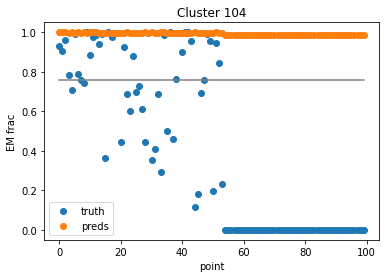

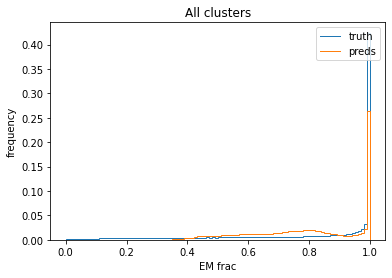

In [56]:
files = ["history_gamma_325_tr_40_tst_40_val_5_epoch_BN_cartesian.npz"]

for file in files:
    print(file)
    history = get_history(file)
    preds = history["preds"][:9000] # 10 s
    print("got preds")   
    labels = history["labels"][:9000]
    print("got labels")    
    #print(history["preds"].shape) # takes 3m to get shape ??

    plot_epoch_loss(history["history"].item())
    #cluster_idxs = [0, 1, 2, 3, 4, 100, 101, 102, 103, 104]
    history_subset = {
        "preds": preds,
        "labels": labels,
    }
    print("mse (all points):", mse_batch(history_subset["preds"], history_subset["labels"]))
    print("mse (no pad):", mse_batch_no_pad(history_subset["preds"], history_subset["labels"]))

    plot_batch_loss(history["loss"])
    for cluster_idx in cluster_idxs:
        plot_clus_pred_acc(cluster_idx, history_subset, False, 0, 100)

    plot_all_clus_acc(history_subset)

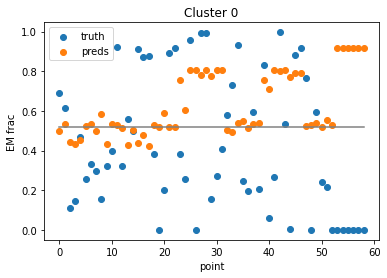

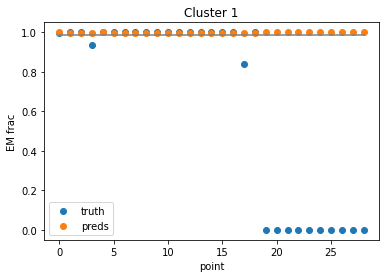

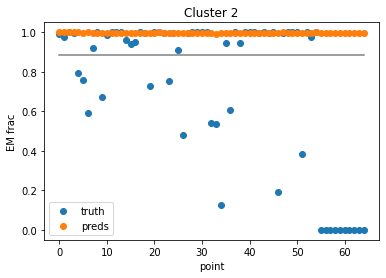

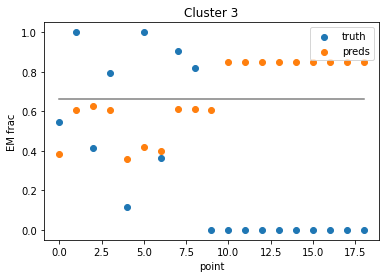

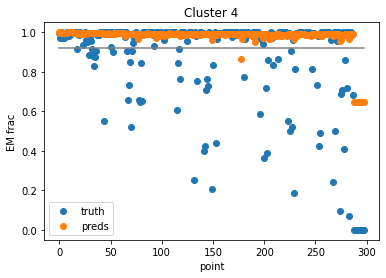

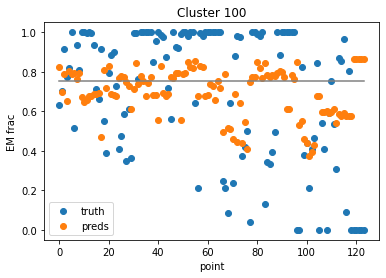

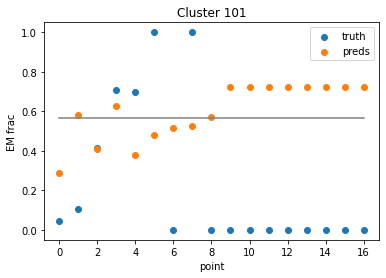

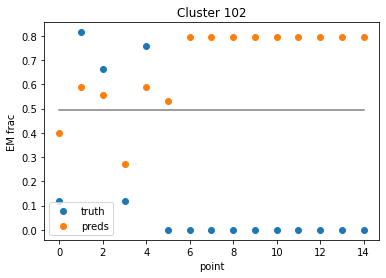

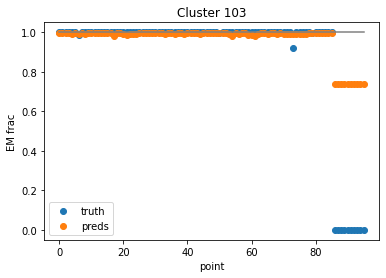

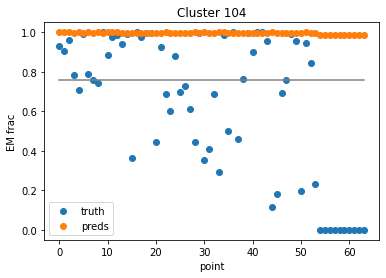

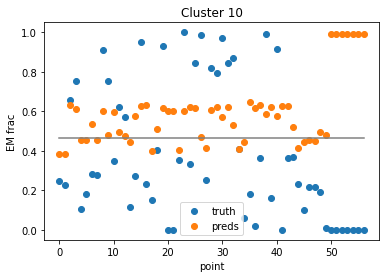

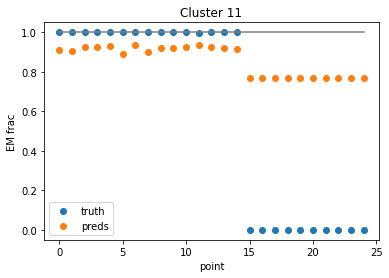

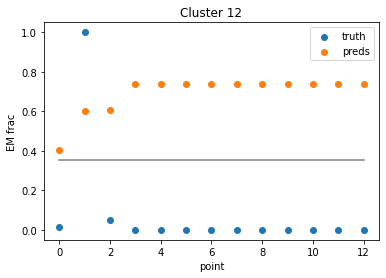

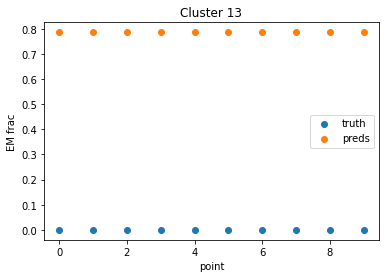

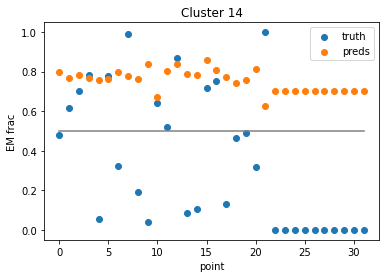

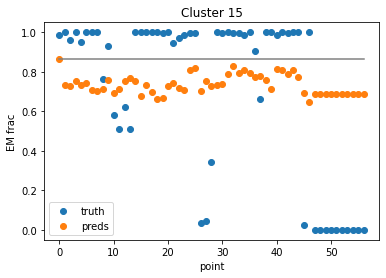

In [59]:
cluster_idxs = [0, 1, 2, 3, 4, 100, 101, 102, 103, 104, 10, 11, 12,13, 14,15]
for cluster_idx in cluster_idxs:
        plot_clus_pred_acc(cluster_idx, history_subset)

history_gamma_1_tr_1_tst_1_val_5_epoch_BN_cartesian_test/history.npz
got preds
got labels


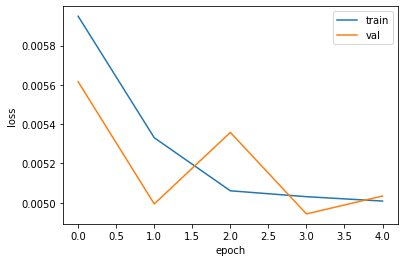

mse (all points): 0.6691228690402261
mse (no pad): 0.10901505435407889


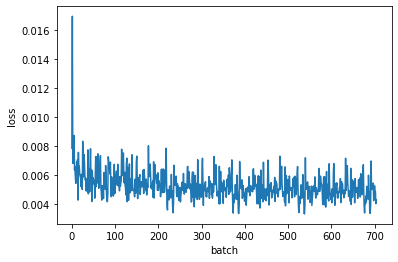

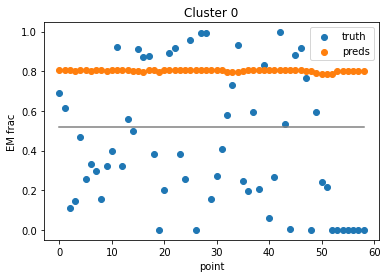

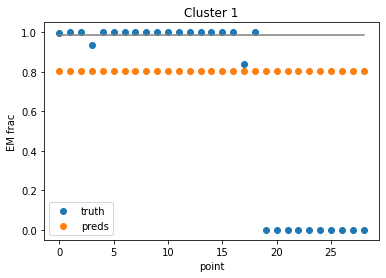

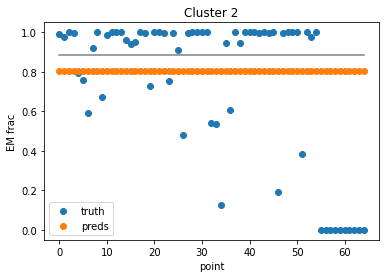

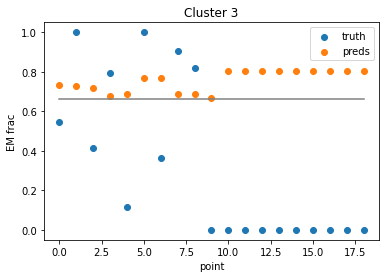

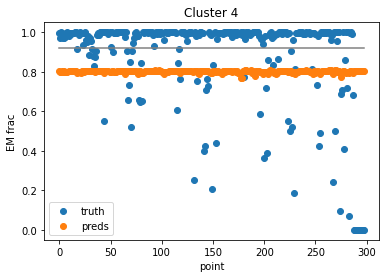

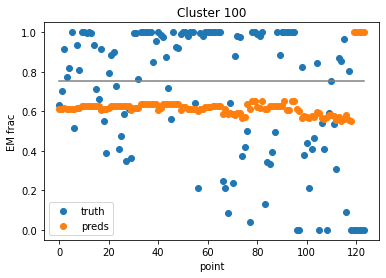

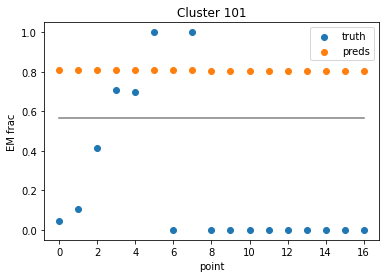

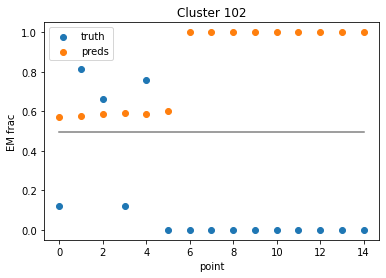

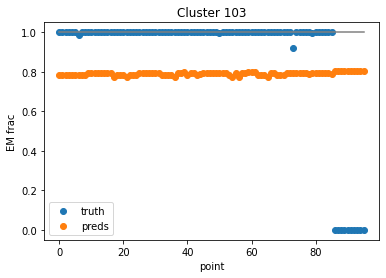

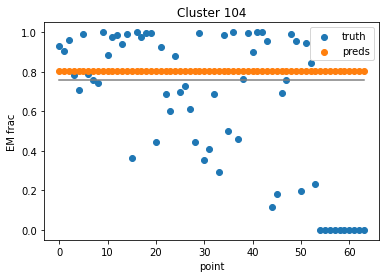

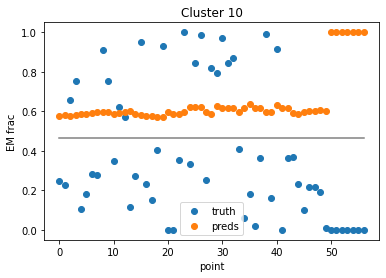

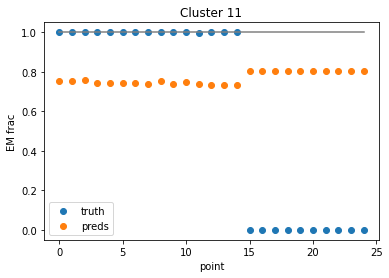

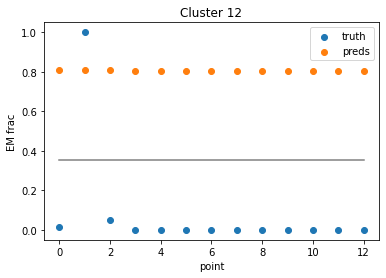

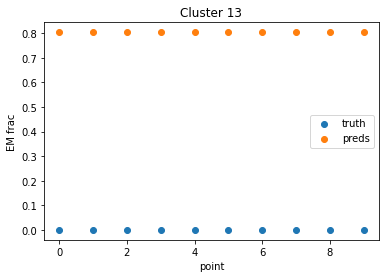

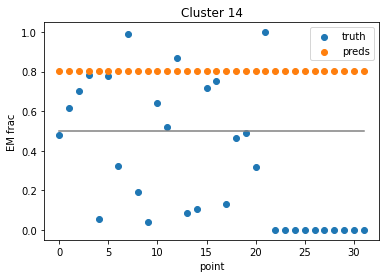

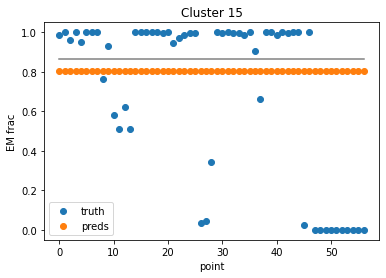

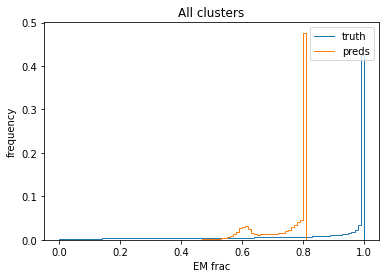

0.11557573865621223


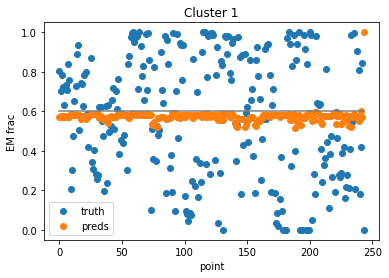

0.11547254711038855


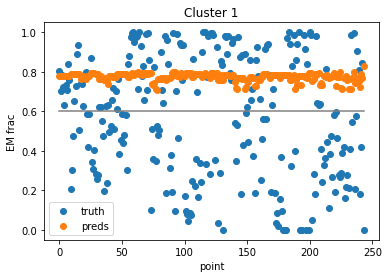

0.10966879913862923


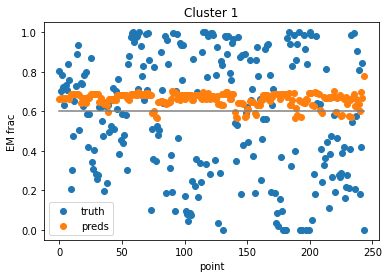

0.11244350164791696


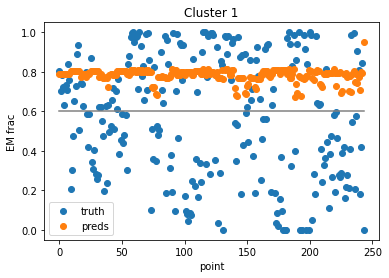

0.10763974140436287


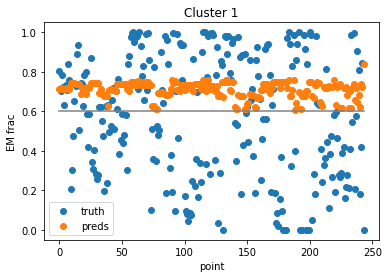

In [84]:
files = ["history_gamma_1_tr_1_tst_1_val_5_epoch_BN_cartesian_test/history.npz"]

for file in files:
    print(file)
    history = get_history(file)
    preds = history["preds"][:9000] # 10 s
    print("got preds")   
    labels = history["labels"][:9000]
    print("got labels")    
    #print(history["preds"].shape) # takes 3m to get shape ??

    plot_epoch_loss(history["history"].item())
    #cluster_idxs = [0, 1, 2, 3, 4, 100, 101, 102, 103, 104]
    history_subset = {
        "preds": preds,
        "labels": labels,
    }
    print("mse (all points):", mse_batch(history_subset["preds"], history_subset["labels"]))
    print("mse (no pad):", mse_batch_no_pad(history_subset["preds"], history_subset["labels"]))

    plot_batch_loss(history["loss"])
    for cluster_idx in cluster_idxs:
        plot_clus_pred_acc(cluster_idx, history_subset)

    plot_all_clus_acc(history_subset)

labels = np.load("/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/history_gamma_1_tr_1_tst_1_val_5_epoch_BN_cartesian_test/labels.npy")
for i in range(5):
    preds = np.load("/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/history_gamma_1_tr_1_tst_1_val_5_epoch_BN_cartesian_test/preds_" + str(i) + ".npy")
    print(mse_batch_no_pad(preds, labels))
    plot_clus_pred_acc(1, {"preds": preds, "labels": labels})

In [73]:
# test splitting epochs
from numpy import genfromtxt
my_data = genfromtxt('/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/history_gamma_1_tr_1_tst_1_val_5_epoch_BN_cartesian_test_history_log.csv', delimiter=',')
print(my_data[1:])

[[0.         0.00589739 0.0056705 ]
 [1.         0.00524507 0.00503456]
 [2.         0.00507276 0.00519241]
 [3.         0.00501483 0.00496156]
 [4.         0.00501441 0.00504926]]


together
epoch 0
0.11962304623999713


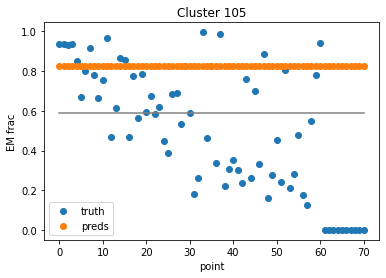

epoch 1
0.10939116132544768


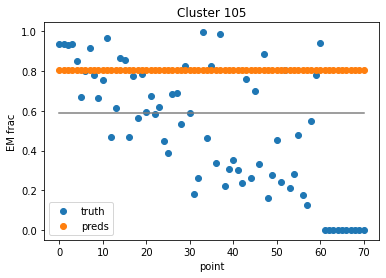

epoch 2
0.11090285163697304


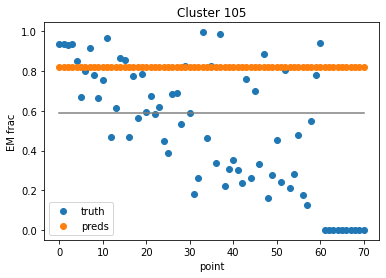

epoch 3
0.11047728800166419


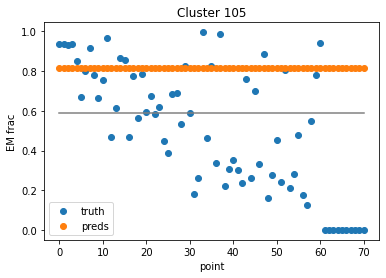

epoch 4
0.11121767593704333


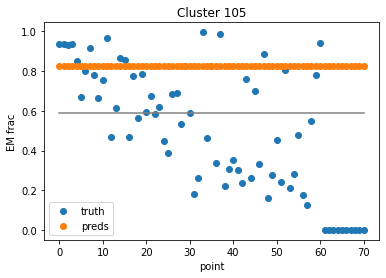

separate
epoch 0
0.11893601016780228


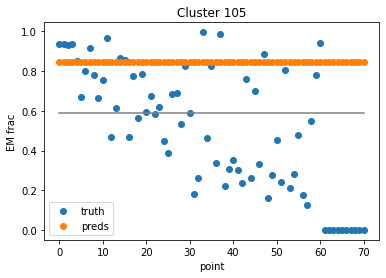

epoch 1
0.12120417830387034


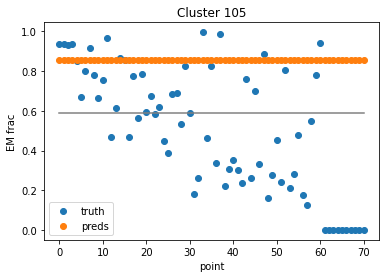

epoch 2
0.10952059618627158


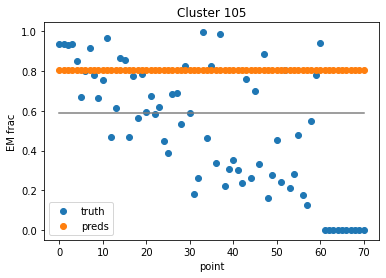

epoch 3
0.10801988317820205


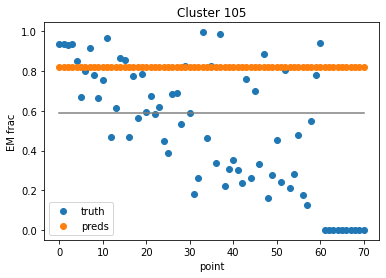

epoch 4
0.11620911227291698


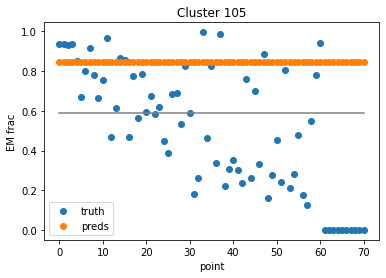

In [13]:
# test splitting epochs
for key_word in ["together", "separate"]:
    print(key_word)
    file_name = "/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/history_gamma_1_tr_1_tst_1_val_5_epoch_BN_cartesian_test_" + key_word
    history = np.load(file_name + "/")
    labels = np.load(file_name +"/tests/labels.npy")
    for i in range(5):
        print("epoch", i)
        preds = np.load(file_name +"/tests/preds_" + str(i) + ".npy")
        print(mse_batch_no_pad(preds, labels))
        plot_clus_pred_acc(105, {"preds": preds, "labels": labels})

{'loss': [0.005729405340182449, 0.005239354213147967, 0.005041854307651343, 0.004975900637158038, 0.004979449487070584], 'val_loss': [0.005374639966421657, 0.005105283805065685, 0.005037969842553139, 0.004899546773897277, 0.004890883165929052]}


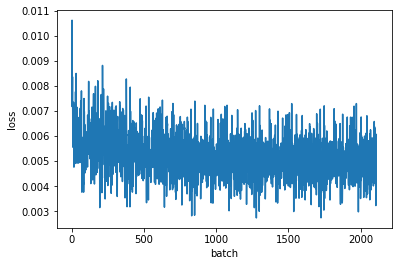

ValueError: could not broadcast input array from shape (1266,) into shape (0,)

In [23]:
# test splitting epochs
file_name = "/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/history_gamma_1_tr_1_tst_1_val_5_epoch_BN_cartesian_test_"
history = np.load(file_name + "together/history_epochs_0_to_5.npz", allow_pickle=True)
print(history["history"])
plot_batch_loss(history["loss"])

history1 = np.load(file_name + "separate/history_epochs_0_to_1.npz", allow_pickle=True)

history2 = np.load(file_name + "separate/history_epochs_1_to_4.npz", allow_pickle=True)

history3 = np.load(file_name + "separate/history_epochs_4_to_5.npz", allow_pickle=True)

loss = np.zeros(len(history1["loss"])+len(history2["loss"])+len(history3["loss"]))
loss[:len(history1["loss"])] = history1["loss"]
loss[len(history1["loss"]):len(history1["loss"])] = history2["loss"]
#loss[-len(history3["loss"]):] = history3["loss"]

plot_batch_loss(loss)

In [70]:
# load all train data
dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/gamma_325_tr_40_tst_40_val_50_epoch_BN_cartesian' 
loss_data = genfromtxt(dir + "/log_loss.csv", delimiter=',').transpose()
loss = loss_data[1]
val_loss = loss_data[2]

num_epochs = 18
preds = []
mse_batch_loss = []
labels = np.load(dir + "/tests/labels.npy")
for epoch in range(num_epochs):
    preds.append(np.load(dir + "/tests/preds_" + str(epoch) + ".npy"))
    mse_batch_loss.append(mse_batch_no_pad(preds[epoch], labels))


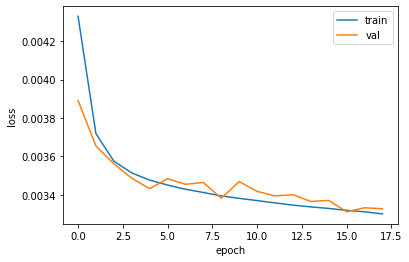

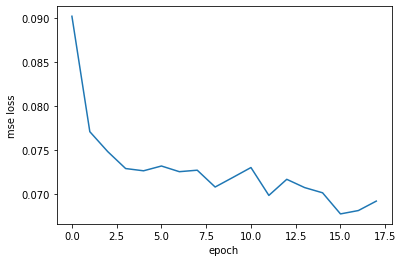

39


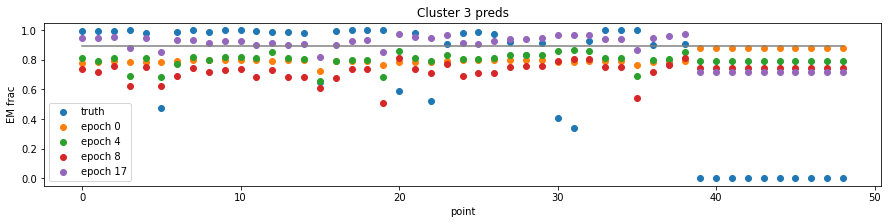

38


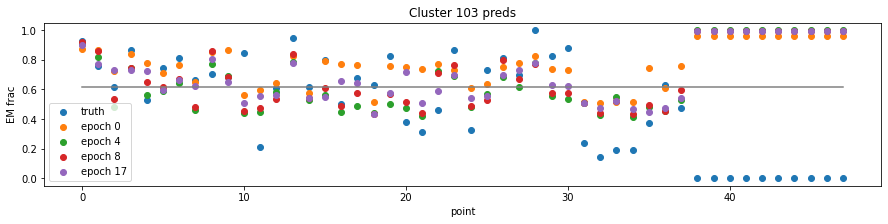

12


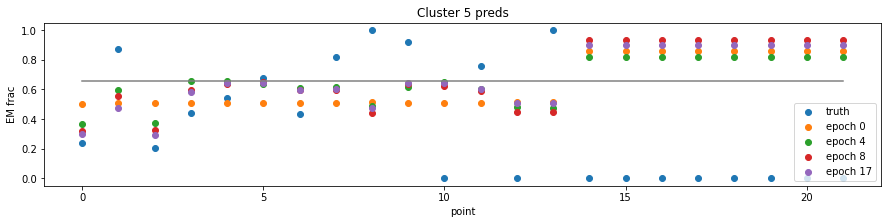

In [73]:
# plot train and val loss
plot_epoch_loss(loss, val_loss)

# plot manually computed mse batch loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(mse_batch_loss)
plt.xlabel("epoch")
plt.ylabel("mse loss")
plt.show()

# plot clusters preds/labels over epochs
epochs = [0, 4, 8, 17]
clusters = [3, 103, 5]
separate = True

plot_clus_preds_acc(clusters, preds, labels, epochs)